In [1]:
% load_ext autoreload
% autoreload 2

In [2]:
import numpy as np
import lightkurve as lk
import threemultis
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting

/Users/ch/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
tpfs = lk.search_targetpixelfile('K2-198').download_all()

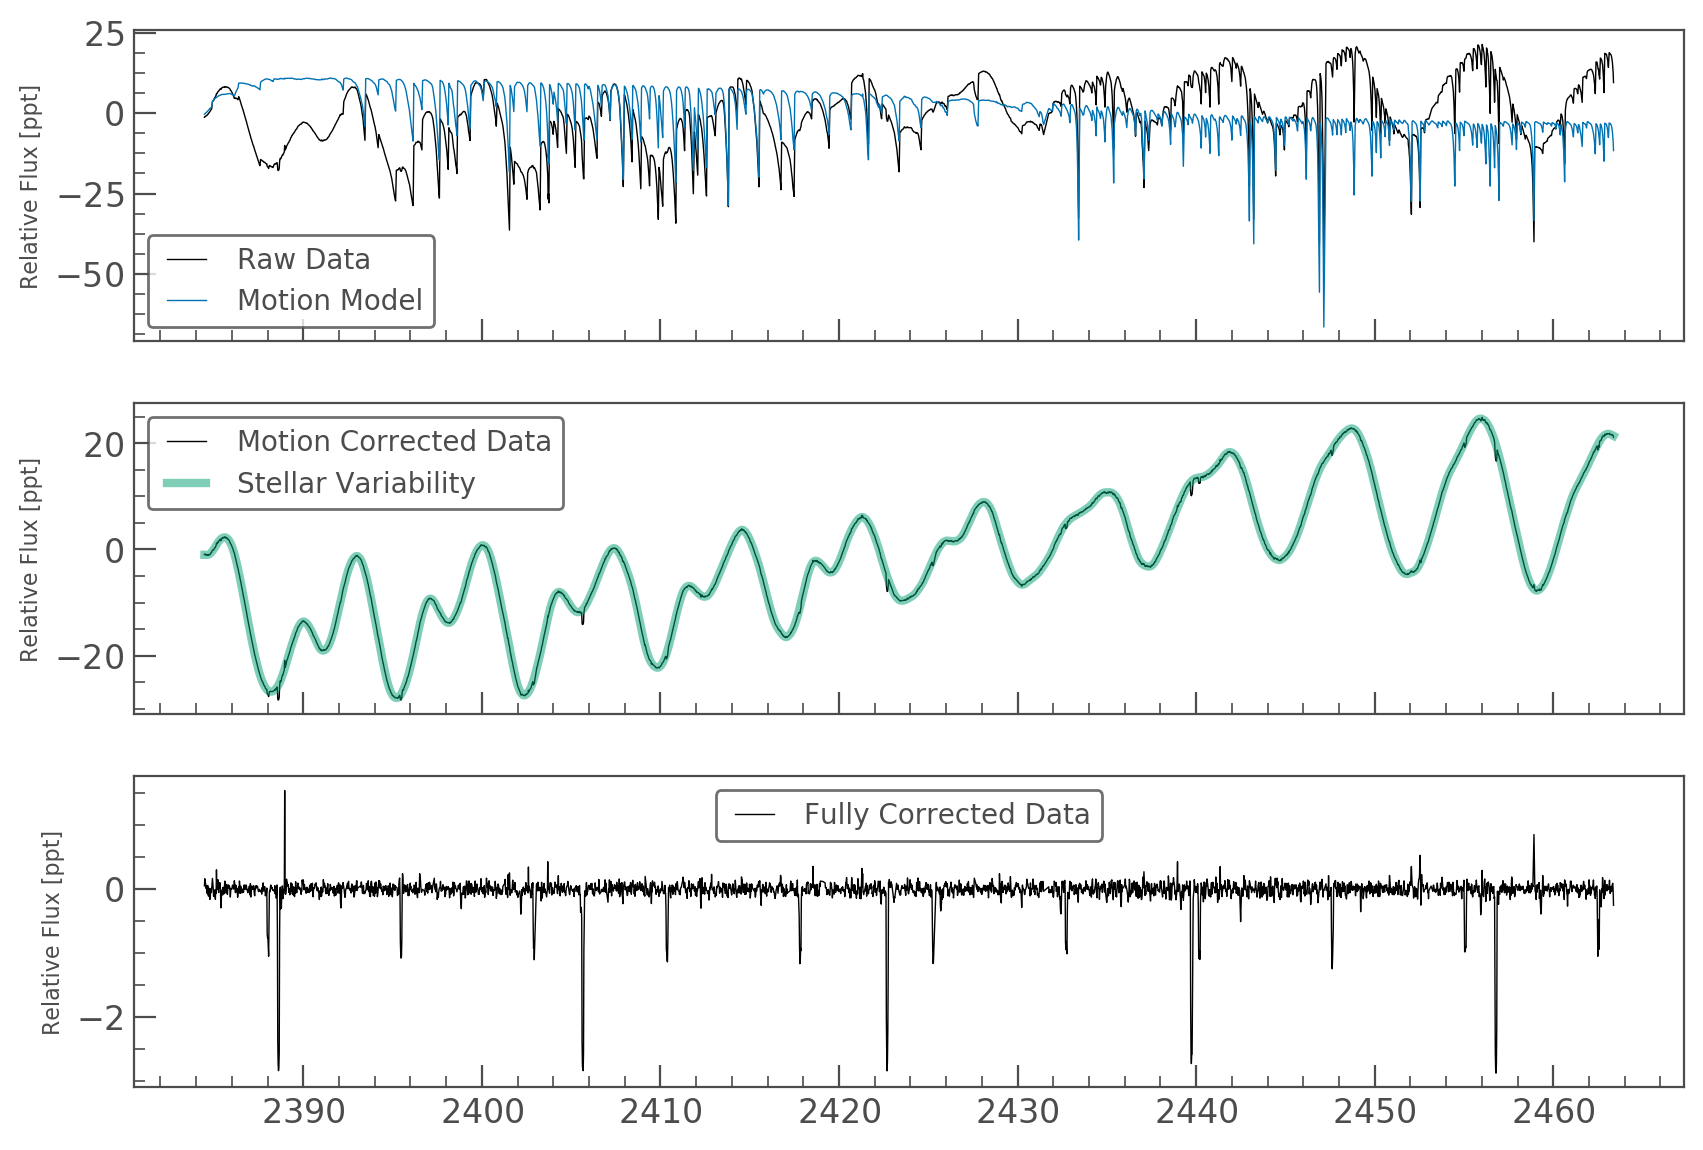

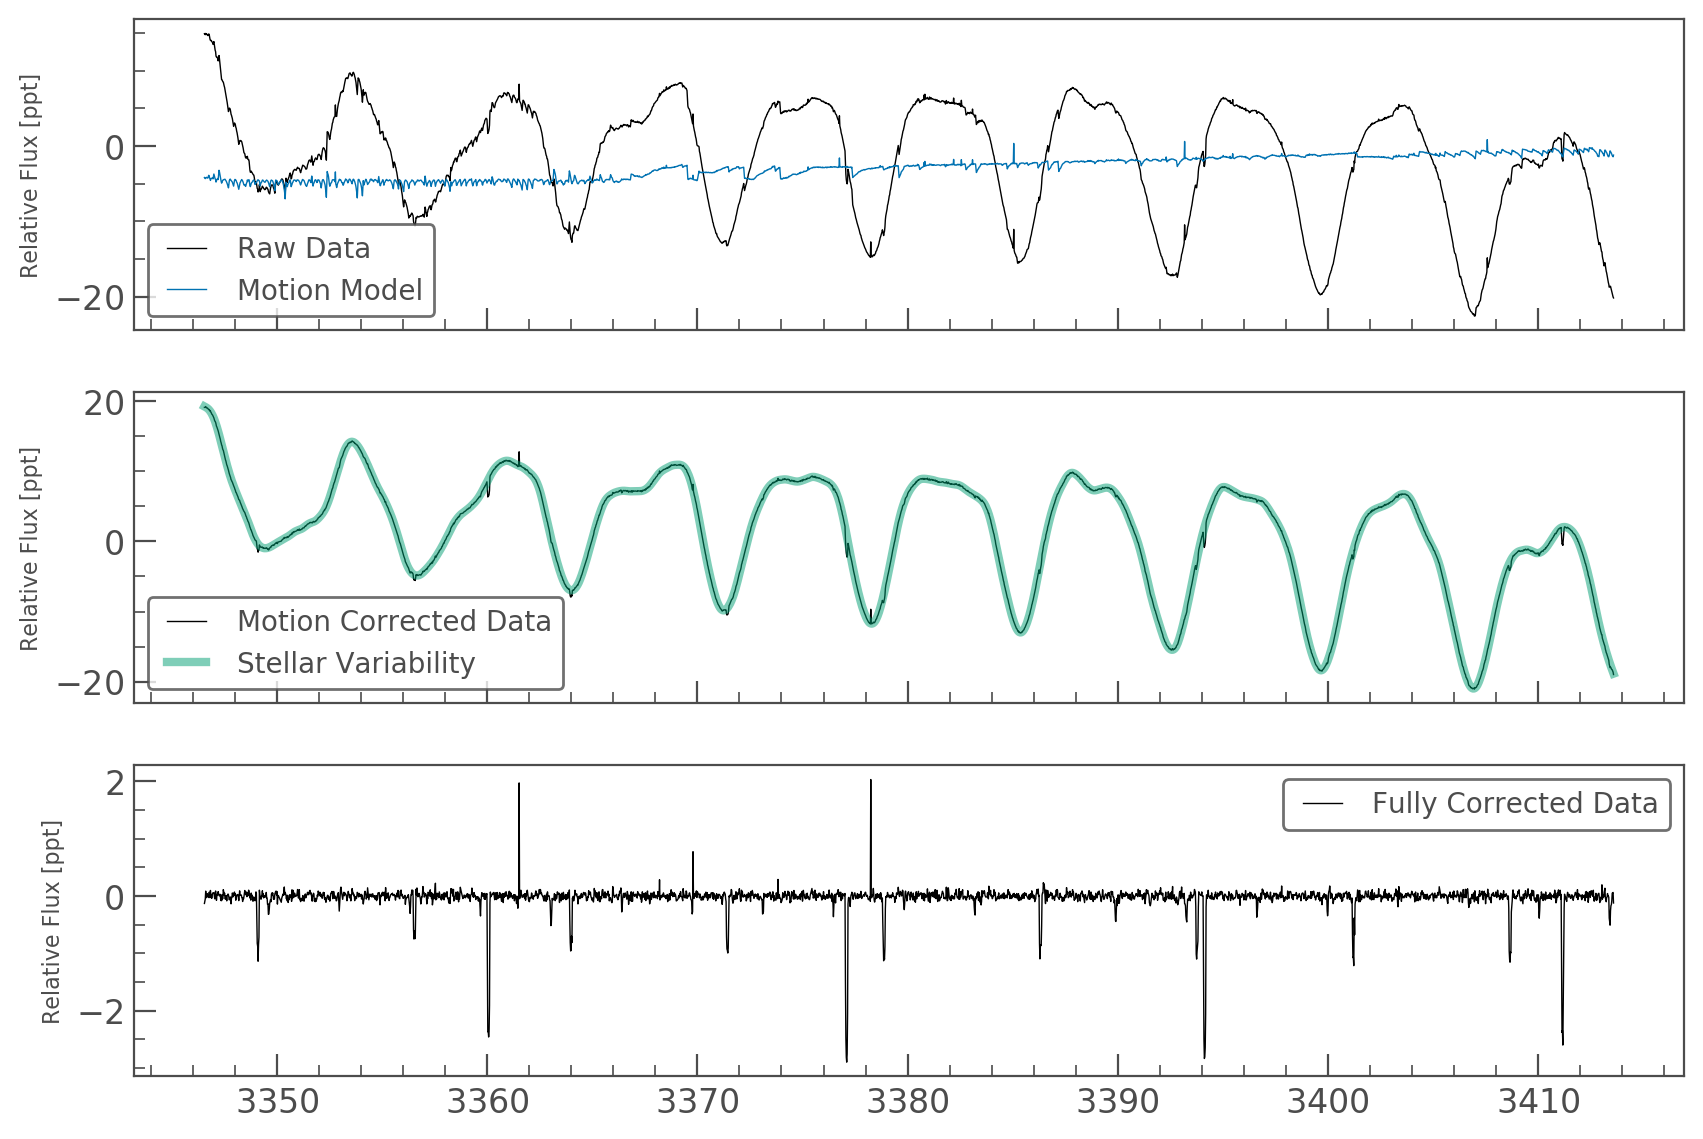

In [7]:
clcs = []     # Corrected Light Curves
for tpf in tpfs:
    tpf = tpf[10:]
    tpf = tpf[np.in1d(tpf.time, tpf.to_lightcurve(aperture_mask='all').remove_nans().time)]
    tpf = tpf[tpf.to_lightcurve().normalize().flux > 0.8]
    
    
    mask = threemultis.utils.planet_mask(tpf.time, 'K2-198')
    clc = threemultis.fit.PLD(tpf, planet_mask=mask, trim=2, return_quick_corrected=True)
    clcs.append(clc)

In [8]:
clc = clcs[0].append(clcs[1])

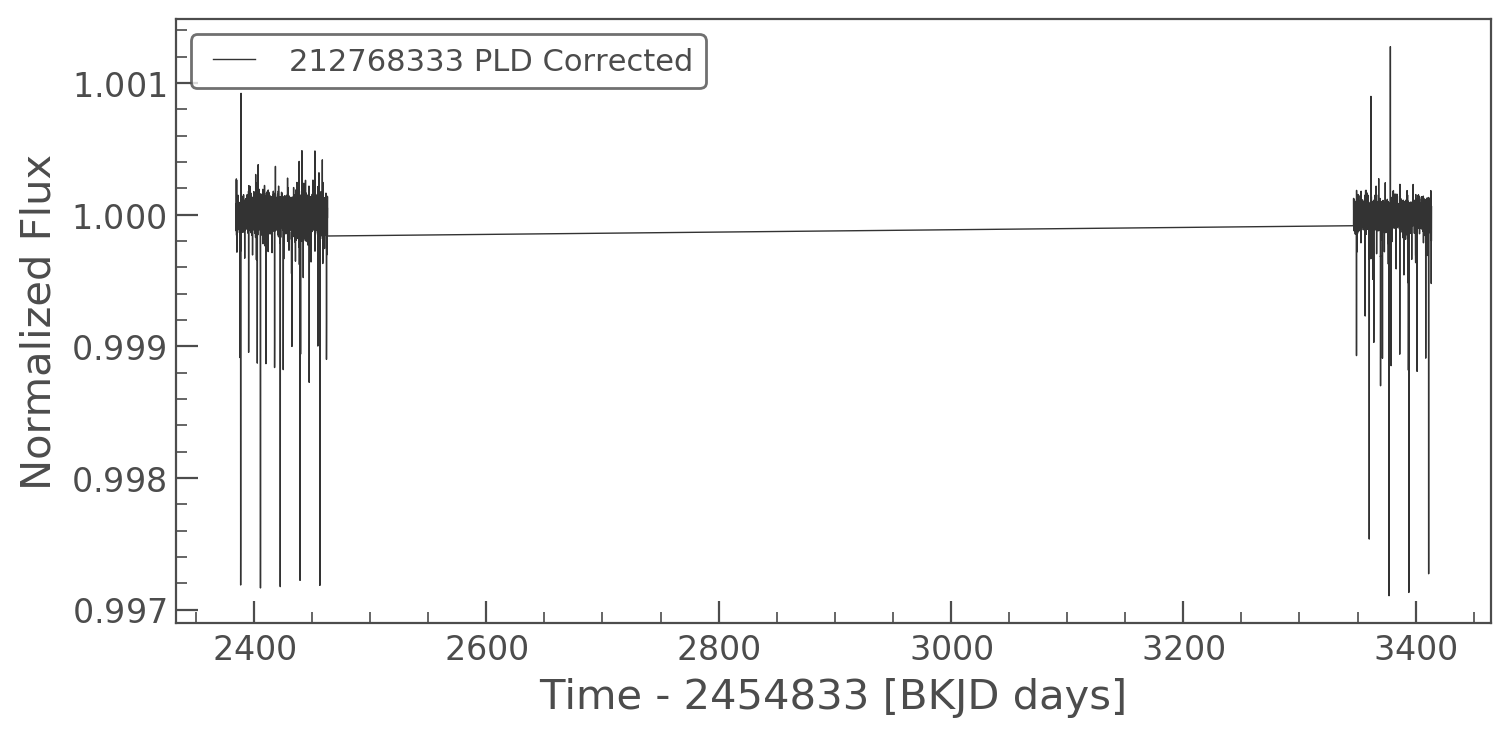

In [9]:
clc.plot();

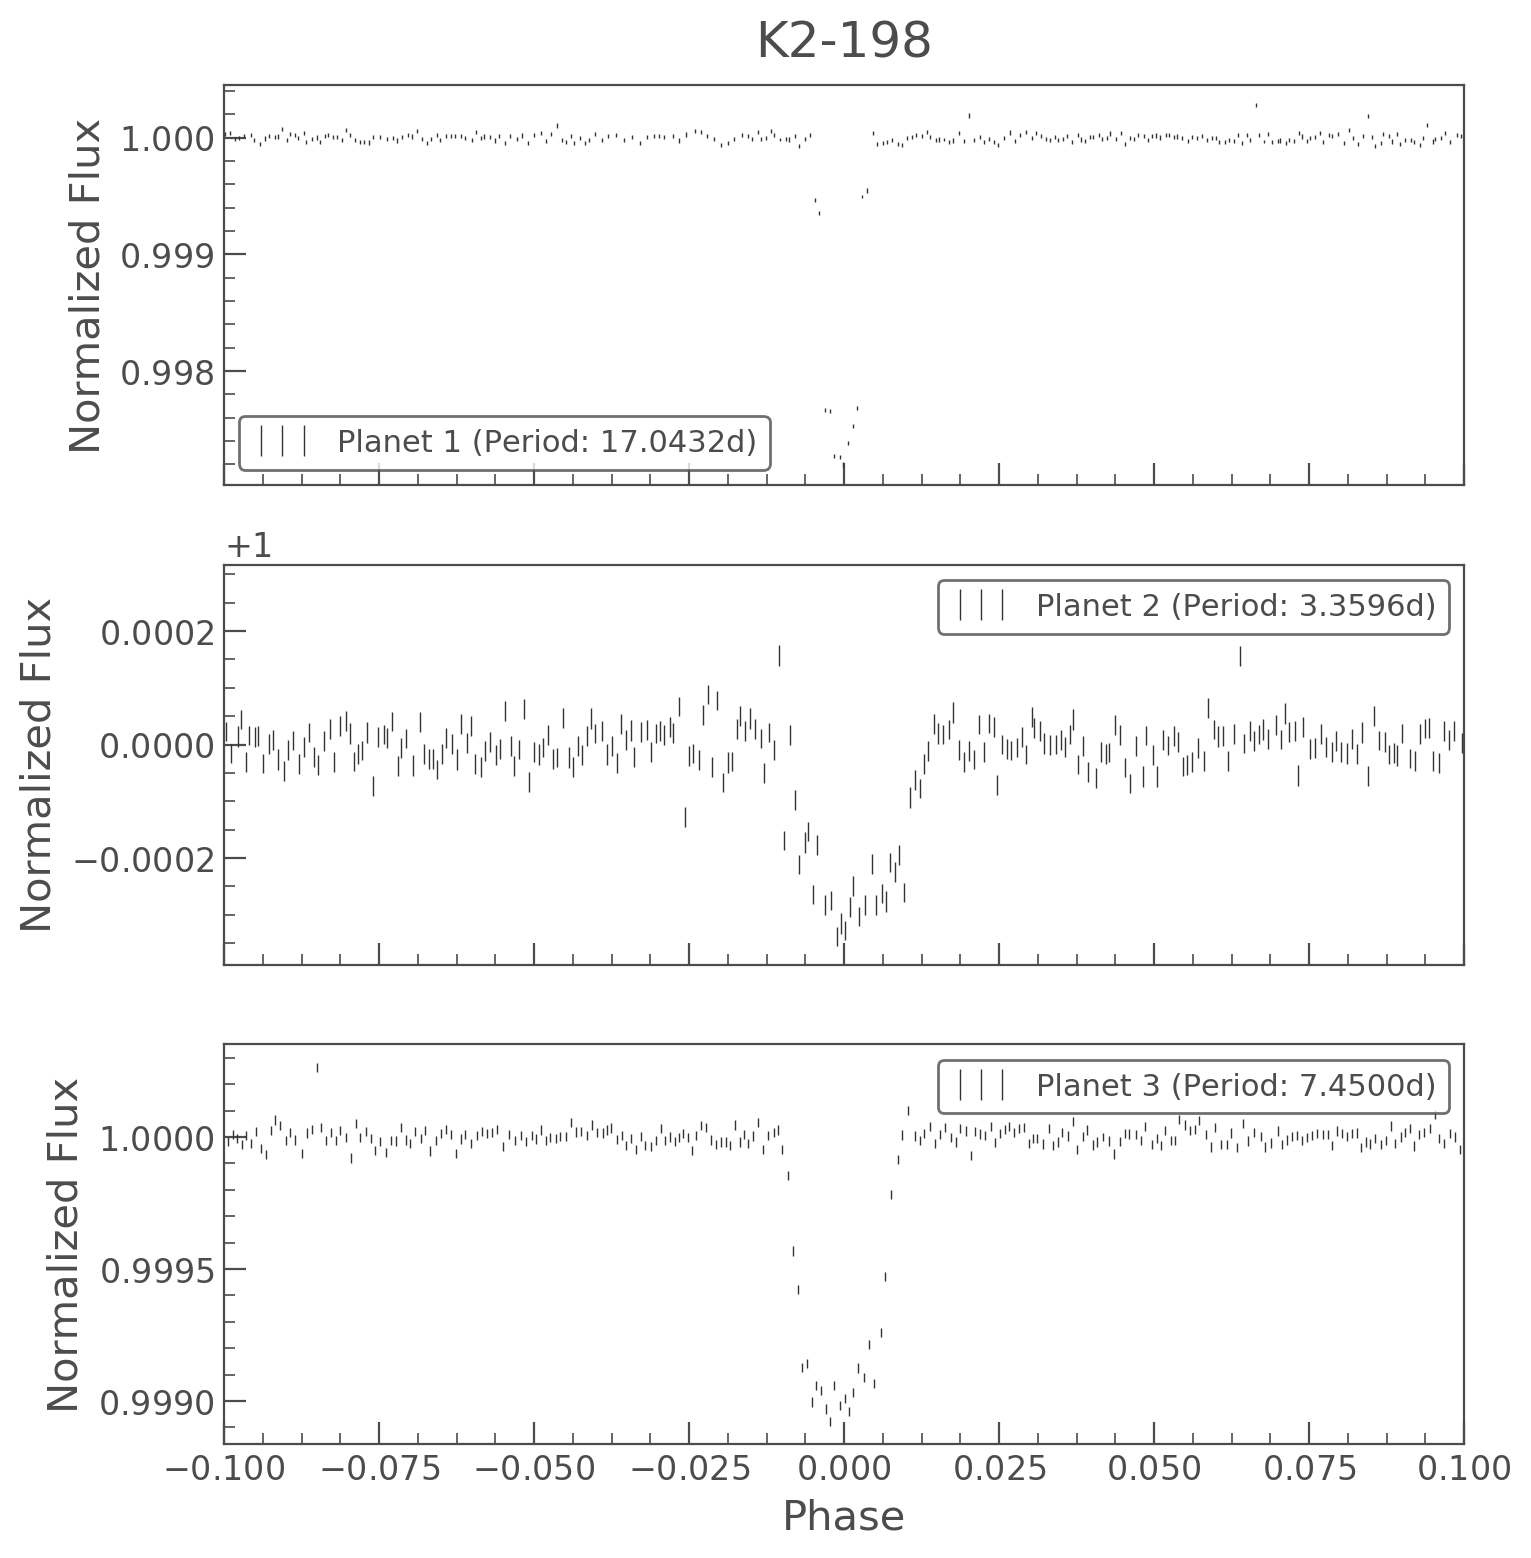

In [12]:
params = threemultis.utils.get_params('K2-198')
threemultis.utils.planet_plot(clc, 'K2-198', nbin=5);

In [ ]:
trace, mask = threemultis.fit.fit_planets(clc, period_value=list(params['Period']),
                                            t0_value=list(params['T0']), depth_value=list(params['Depth']),
                                            R_star=(params.loc[0, 'R_star'], params.loc[0, 'R_star_error']),
                                            M_star=(params.loc[0, 'M_star'], params.loc[0, 'M_star_error']),
                                            T_star=(params.loc[0, 'T_star'], params.loc[0, 'T_star_error']), ndraws=40)

In [ ]:
import pymc3 as pm
import corner
import astropy.units as u
varnames = varnames=["r_pl", "b", "t0", "logP", "r_star", "m_star", "u_star", "mean"]
samples = pm.trace_to_dataframe(trace, varnames=varnames)

# Convert the radius to Earth radii
samples["r_pl__0"] = (np.array(samples["r_pl__0"]) * u.R_sun).to(u.R_earth).value
samples["r_pl__1"] = (np.array(samples["r_pl__1"]) * u.R_sun).to(u.R_earth).value


corner.corner(samples);

In [ ]:
threemultis.utils.plot_folded_transits(clc, trace, mask, 'K2-198')

In [ ]:
threemultis.utils.latex_trace(trace, 'K2-198')

In [ ]:
params = threemultis.utils.get_params('K2-198')
fig, axs = plt.subplots(len(params), 1, figsize=(8, 3 * len(params)))
for planet, df in params.iterrows():
    otherplanets = list(set(list(np.arange(len(params)))) - set([planet]))
    mask = np.ones(len(clc.time), bool)
    for op in otherplanets:
        p1 = params.loc[op, 'Period']
        t01 = params.loc[op, 'T0']
        d1 = params.loc[op, 'Duration']
        x_fold = (clc.time - t01 + 0.5*p1) % p1 - 0.5*p1
        mask &= (np.abs(x_fold) > d1/2)

    p = df['Period']
    t0 = df['T0']
    d = df['Duration']
    x_fold = (clc.time - t0 + 0.5*p) % p - 0.5*p
    periodogram = clc[mask].to_periodogram('bls', duration=np.linspace(d-0.1, d+0.1, 10),
                                           minimum_period=p-0.005, maximum_period=p+0.005, frequency_factor=1)
    periodogram.plot(ax=axs[planet], label='Planet {} (Period: {:2.4f}d)'.format(planet + 1, p))
    
    
    g_init = (models.Gaussian1D(periodogram.power.value.max(), periodogram.period.value.mean(), 0.0002) +
                models.Gaussian1D(periodogram.power.value.max()*0.1, periodogram.period.value.mean(), 0.0004) +
                 models.Gaussian1D(periodogram.power.value.max()*0.01, periodogram.period.value.mean(), 0.0006))

    fit = fitting.LevMarLSQFitter()
    g = fit(g_init, periodogram.period.value, periodogram.power.value)
    mean = getattr(g, 'mean_{}'.format(np.argmax([g.amplitude_0, g.amplitude_1]))).value
    axs[planet].plot(periodogram.period.value, g(periodogram.period.value))
    axs[planet].axvline(mean, ls='--')
    pos = np.argmin(np.abs(periodogram.period.value - mean))
    period, t0 = periodogram.period[pos].value, periodogram.transit_time[pos]

    if planet < len(params) - 1:
        axs[planet].set_xlabel('')
    if planet == 0:
        axs[planet].set_title('K2-198')
    print(planet, period, t0)